In [1]:
!pip install --upgrade pip

In [2]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
# !pip install torchcodec
!pip install -U typing_extensions

import torch; torch._dynamo.config.recompile_limit = 64;

In [3]:
%%capture
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [4]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3n-E4B-it",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.9: Fast Gemma3N patching. Transformers: 4.56.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.422 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

In [5]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 193.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 161.3 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3━━━━━ 0/2 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]


In [ ]:
from huggingface_hub import login
import os

# Paste your token here (get it from: https://huggingface.co/settings/tokens)
HF_TOKEN = "" 

login(token=HF_TOKEN)

In [7]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [8]:
!pip uninstall torchcodec -y

In [15]:
from datasets import load_dataset, Video

dataset = load_dataset("blind-assist/walk", split="test").cast_column("video", Video(decode=False))
dataset = dataset.select(range(50))

Resolving data files:   0%|          | 0/1008 [00:00<?, ?it/s]

test/20240918_short_ead2195dd00d4e0e39b9(…):   0%|          | 0.00/593k [00:00<?, ?B/s]

test/20240918_short_ead2195dd00d4e0e39b9(…):   0%|          | 0.00/522k [00:00<?, ?B/s]

test/20240918_short_d97f77c854ebf5207e30(…):   0%|          | 0.00/745k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/519k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/465k [00:00<?, ?B/s]

test/20240918_short_ead2195dd00d4e0e39b9(…):   0%|          | 0.00/668k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/614k [00:00<?, ?B/s]

test/20240918_short_d97f77c854ebf5207e30(…):   0%|          | 0.00/675k [00:00<?, ?B/s]

test/20240918_short_d3a12c48750e8d2b0023(…):   0%|          | 0.00/577k [00:00<?, ?B/s]

test/20240918_short_d97f77c854ebf5207e30(…):   0%|          | 0.00/792k [00:00<?, ?B/s]

test/20240918_short_d3a12c48750e8d2b0023(…):   0%|          | 0.00/487k [00:00<?, ?B/s]

test/20240918_short_d3a12c48750e8d2b0023(…):   0%|          | 0.00/679k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/565k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/719k [00:00<?, ?B/s]

test/20240918_short_ead2195dd00d4e0e39b9(…):   0%|          | 0.00/656k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/584k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/610k [00:00<?, ?B/s]

test/20240919_short_395a39dab4fc329ed6ed(…):   0%|          | 0.00/516k [00:00<?, ?B/s]

test/20240918_short_f065e59be08cb5c66e3b(…):   0%|          | 0.00/539k [00:00<?, ?B/s]

test/20240919_short_abdcc6b0252ca514a65d(…):   0%|          | 0.00/565k [00:00<?, ?B/s]

test/20240919_short_395a39dab4fc329ed6ed(…):   0%|          | 0.00/480k [00:00<?, ?B/s]

test/20240919_short_395a39dab4fc329ed6ed(…):   0%|          | 0.00/458k [00:00<?, ?B/s]

test/20240919_short_abdcc6b0252ca514a65d(…):   0%|          | 0.00/777k [00:00<?, ?B/s]

test/20240919_short_abdcc6b0252ca514a65d(…):   0%|          | 0.00/527k [00:00<?, ?B/s]

test/20240919_short_abdcc6b0252ca514a65d(…):   0%|          | 0.00/572k [00:00<?, ?B/s]

test/20240919_short_abdcc6b0252ca514a65d(…):   0%|          | 0.00/485k [00:00<?, ?B/s]

test/20240919_short_abdcc6b0252ca514a65d(…):   0%|          | 0.00/544k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1007 [00:00<?, ? examples/s]

In [16]:
dataset

Dataset({
    features: ['frame_path', 'weather_condition', 'area_type', 'danger_level', 'traffic_flow_rating', 'summary', 'alter', 'video', 'video_id'],
    num_rows: 50
})

In [17]:
dataset[2]["video"]

{'bytes': None,
 'path': '/root/.cache/huggingface/hub/datasets--blind-assist--walk/snapshots/ca890433d36693e4643f60302e56a6c8622dcafc/test/20240918-youtube_short_0830abed85f2fa636452919d74cc2b14_2m21s.mp4'}

In [18]:
dataset[2]["alter"]

"at one o'clock direction, there are pedestrians taking pictures. beware of avoiding them."

In [19]:
import cv2
import numpy as np
from PIL import Image

def downsample_video(video_path, num_frames=8):
    """Extracts evenly spaced frames for VLM context."""
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0: return []
    
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for i in indices:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, image = vidcap.read()
        if success:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(image))
    vidcap.release()
    return frames

In [20]:
def convert_to_conversation(sample):
    frames = downsample_video(sample["video"]["path"])
    
    # Constructing the message content with interleaved text and images
    user_content = [{"type": "text", "text": "Based on this walking path video, provide navigation advice."}]
    for img in frames:
        user_content.append({"type": "image", "image": img})
        
    return {
        "messages": [
            {"role": "user", "content": user_content},
            {"role": "assistant", "content": [{"type": "text", "text": sample["alter"]}]}
        ]
    }

In [21]:
converted_dataset = [convert_to_conversation(s) for s in dataset]

In [22]:
converted_dataset[2]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Based on this walking path video, provide navigation advice.'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1920x1080>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': "at one o'clock direction, there are pedestrians taking pictures. beware of avoiding them."}]}]}

In [41]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 124.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 95.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 177.5 MB/s  0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


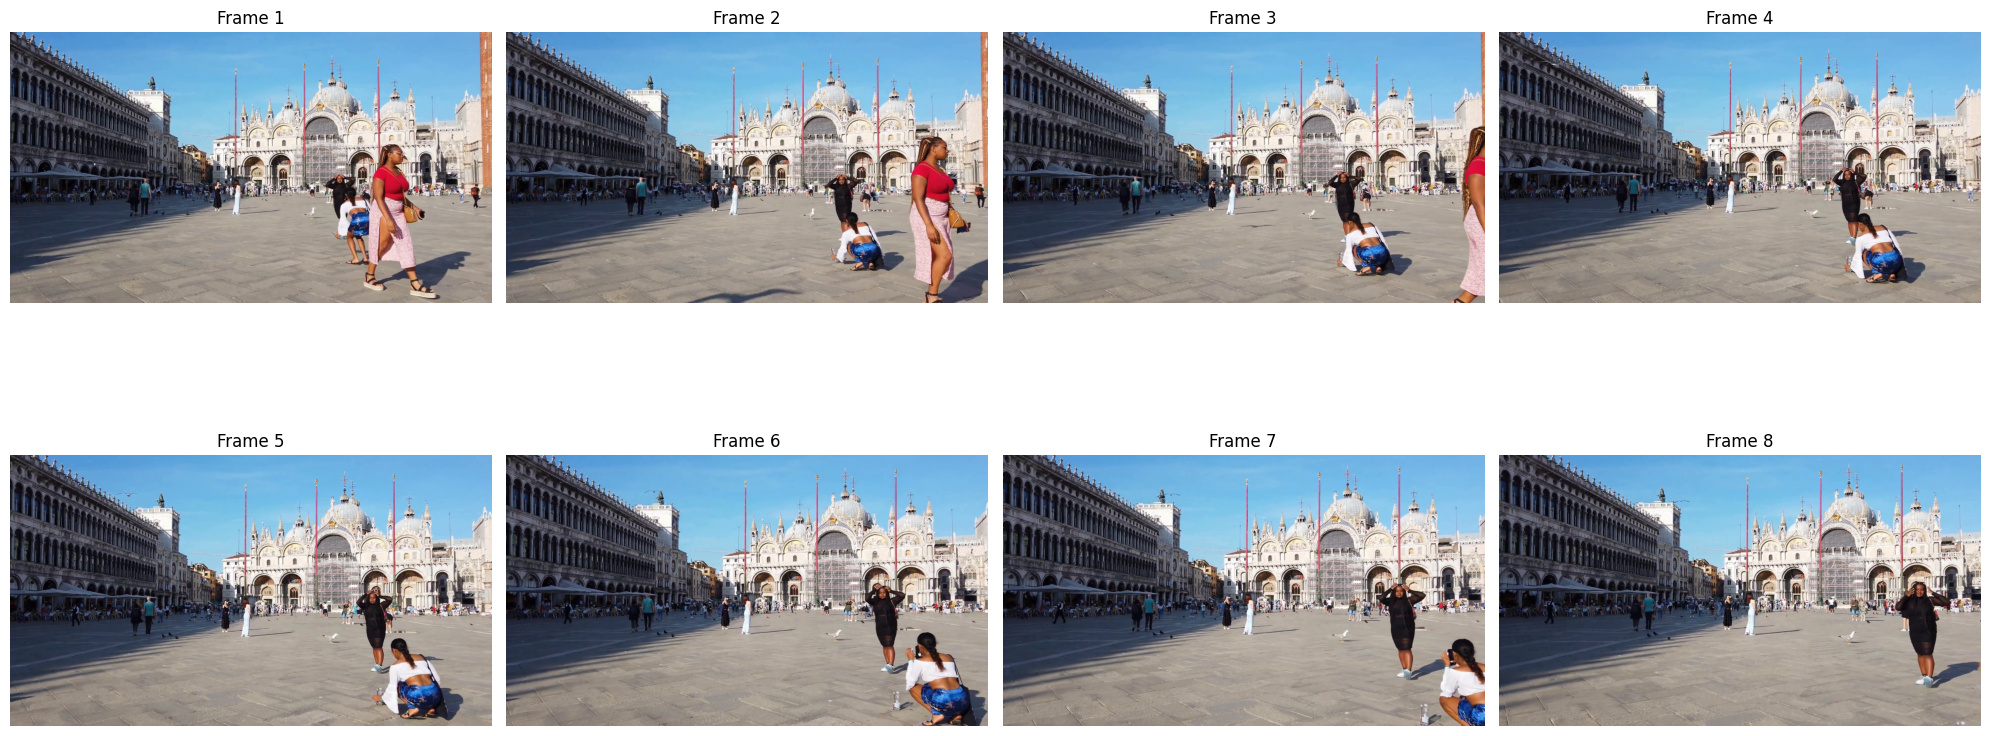

In [42]:
import matplotlib.pyplot as plt
vid = converted_dataset[2]
# 1. Extract only the image objects from your content list
images = [c['image'] for c in vid['messages'][0]['content'] if c['type'] == 'image']

# 2. Plot them in a grid
plt.figure(figsize=(20, 10))
for i, img in enumerate(images):
    plt.subplot(2, 4, i + 1) # 2 rows, 4 columns
    plt.imshow(img)
    plt.title(f"Frame {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3n"
)

In [34]:
# 1. Enable Unsloth optimized inference
FastVisionModel.for_inference(model)

# 2. Select and prepare the video data
sample = dataset[2]
video_path = sample["video"]["path"]
print(f"Evaluating Video: {video_path}")

# FIX: Get frames directly. Since downsample_video returns 
# a list of images, we don't need to index them.
frames = downsample_video(video_path)

# 3. Construct the Multimodal Message
instruction = "What is in these image inputs? Provide navigation advice for the walking path."
messages = [{"role": "user", "content": [{"type": "text", "text": instruction}]}]

# Interleave the extracted frames into the message content
for img in frames:
    messages[0]["content"].append({"type": "image", "image": img})

# 4. Apply Chat Template and Process Inputs
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Feed BOTH the text AND the actual images to the processor
inputs = processor(
    images = frames,        # Pass the list of 8 PIL images here
    text = input_text,     
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Evaluating Video: /root/.cache/huggingface/hub/datasets--blind-assist--walk/snapshots/ca890433d36693e4643f60302e56a6c8622dcafc/test/20240918-youtube_short_0830abed85f2fa636452919d74cc2b14_2m21s.mp4
The images show **Piazza San Marco (St. Mark's Square)** in Venice, Italy. The square is large and paved with large stone blocks. The most prominent feature is the **Basilica di San Marco**, a magnificent cathedral with a large dome and ornate facade. The square is surrounded by historic buildings with arched windows. 

**Navigation Advice:**

* **Main areas:** The square is very open, so you can easily walk around. 
* **Basilica:** The Basilica di San Marco is the central landmark. You can walk around it and explore its various entrances.
* **Surrounding buildings:** The


In [35]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor, max_seq_length=50000),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 6,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.001,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 50000,
    )
)

Unsloth: Model does not have a default image size - using 512


In [36]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A40. Max memory = 44.422 GB.
12.047 GB of memory reserved.


In [37]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 50 | Num Epochs = 1 | Total steps = 6
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 76,840,960 of 7,926,819,152 (0.97% trained)


Step,Training Loss
1,12.844800
2,12.814000
3,4.670700
4,3.346400
5,2.383200
6,1.665000


In [38]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

128.8394 seconds used for training.
2.15 minutes used for training.
Peak reserved memory = 14.373 GB.
Peak reserved memory for training = 2.326 GB.
Peak reserved memory % of max memory = 32.356 %.
Peak reserved memory for training % of max memory = 5.236 %.


In [39]:
# 1. Enable Unsloth optimized inference
FastVisionModel.for_inference(model)

# 2. Select and prepare the video data
sample = dataset[2]
video_path = sample["video"]["path"]
print(f"Evaluating Video: {video_path}")

# FIX: Get frames directly. Since downsample_video returns 
# a list of images, we don't need to index them.
frames = downsample_video(video_path)

# 3. Construct the Multimodal Message
instruction = "What is in these image inputs? Provide navigation advice for the walking path."
messages = [{"role": "user", "content": [{"type": "text", "text": instruction}]}]

# Interleave the extracted frames into the message content
for img in frames:
    messages[0]["content"].append({"type": "image", "image": img})

# 4. Apply Chat Template and Process Inputs
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Feed BOTH the text AND the actual images to the processor
inputs = processor(
    images = frames,        # Pass the list of 8 PIL images here
    text = input_text,     
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Evaluating Video: /root/.cache/huggingface/hub/datasets--blind-assist--walk/snapshots/ca890433d36693e4643f60302e56a6c8622dcafc/test/20240918-youtube_short_0830abed85f2fa636452919d74cc2b14_2m21s.mp4
The images show **St. Mark's Square in Venice, Italy**. The main focus is on **St. Mark's Basilica**, a large and ornate cathedral with multiple domes and intricate decorations. The square is paved with large stone blocks and is surrounded by historical buildings with arched windows. 

**Navigation Advice:**

* **St. Mark's Basilica:** This is the most prominent landmark in the square. It's a must-see and offers stunning architecture and history.
* **Doge's Palace:** Located to the west of the square, this palace is another significant historical building.
* **Campan


In [ ]:
model.save_pretrained("lora_model")  # Local saving
processor.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
if False:
    from unsloth import FastVisionModel

    model, processor = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,  # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

FastVisionModel.for_inference(model)  # Enable for inference!

# 2. Select and prepare the video data
sample = dataset[2]
video_path = sample["video"]["path"]
print(f"Evaluating Video: {video_path}")

# FIX: Get frames directly. Since downsample_video returns 
# a list of images, we don't need to index them.
frames = downsample_video(video_path)

# 3. Construct the Multimodal Message
instruction = "What is in these image inputs? Provide navigation advice for the walking path."
messages = [{"role": "user", "content": [{"type": "text", "text": instruction}]}]

# Interleave the extracted frames into the message content
for img in frames:
    messages[0]["content"].append({"type": "image", "image": img})

# 4. Apply Chat Template and Process Inputs
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

# Feed BOTH the text AND the actual images to the processor
inputs = processor(
    images = frames,        # Pass the list of 8 PIL images here
    text = input_text,     
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")